# Прекод

# Сборный проект-5

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [64]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from math import ceil
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForMaskedLM, BertTokenizer


import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_score


from catboost import CatBoostRegressor

import spacy
import re

import textwrap


# Progress bars
from tqdm.notebook import tqdm

# Dataset
from tensorflow.keras.datasets import fashion_mnist

# Model construction
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dropout, Conv2D, AveragePooling2D, 
                                   GlobalAveragePooling2D, Flatten, Dense, BatchNormalization)

# Optimization and preprocessing
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pretrained models
from tensorflow.keras.applications.resnet import ResNet50


from tensorflow.keras.metrics import RootMeanSquaredError

from tensorflow.keras.callbacks import EarlyStopping


from PIL import Image
import os



img_folder_path = 'C:/Users/PC/Documents/Practicum/DataSceince/sborny_5/to_upload/train_images'
img_folder_path_test = 'C:/Users/PC/Documents/Practicum/DataSceince/sborny_5/to_upload/test_images'
RANDOM_STATE = 42

### Загрузка данных

In [2]:
try:
    train_df = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/sborny_5/to_upload/train_dataset.csv')
except:
    train_df = pd.read_csv('/to_upload/train_dataset.csv')

In [3]:
try:
    test_queries_df = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/sborny_5/to_upload/test_queries.csv', sep='|', index_col=[0])
except:
    test_queries_df = pd.read_csv('/to_upload/test_queries.csv', sep='|', index_col=[0])

In [4]:
try:
    test_images_df = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/sborny_5/to_upload/test_images.csv')
except:
    test_images_df = pd.read_csv('/to_upload/test_images.csv')

In [5]:
columns = ['image', 'query_id', 'crowd_rate', 'positive_num', 'nagative_num']
try:
    df_crowd = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/sborny_5/to_upload/CrowdAnnotations.tsv',
                           sep='\t',
                           names=columns)
except:
    df_crowd = pd.read_csv('/to_upload/CrowdAnnotations.tsv',
                           sep='\t',
                           names=columns)

In [6]:
columns = ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3']
try:
    df_expert = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/sborny_5/to_upload/ExpertAnnotations.tsv',
                            sep='\t',
                            names=columns)
except:
    df_expert = pd.read_csv('/to_upload/ExpertAnnotations.tsv',
                            sep='\t',
                            names=columns)

In [7]:
# функция выводит первые 5 строк датафрейма, общую информацию и описат.статистики
def func_info(data):
    display(data.head(5))
    display(data.describe())
    data.info()

Посмотрим на заугруженные данные

In [8]:
print('train_dataset.csv')
func_info(train_df)
print()
print()
print('test_queries.csv')
func_info(test_queries_df)
print()
print()
print('test_images.csv')
func_info(test_images_df)
print()
print()
print('CrowdAnnotations.tsv')
func_info(df_crowd)
print()
print()
print('ExpertAnnotations.tsv')
func_info(df_expert)

train_dataset.csv


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


test_queries.csv


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


test_images.csv


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

image
count                         100
unique                        100
top     3356748019_2251399314.jpg
freq                            1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


CrowdAnnotations.tsv


image                     query_id  crowd_rate  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2         1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2         0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2         0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2         0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2         0.0   

   positive_num  nagative_num  
0             3             0  
1             0             3  
2             0             3  
3             0             3  
4             0             3

crowd_rate  positive_num  nagative_num
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   crowd_rate    47830 non-null  float64
 3   positive_num  47830 non-null  int64  
 4   nagative_num  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


ExpertAnnotations.tsv


image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

expert_1     expert_2     expert_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Сначала посмотрим распределение оценок краудсорсинга и оценок экспертов. Далее создадим агрегированный индекс.   

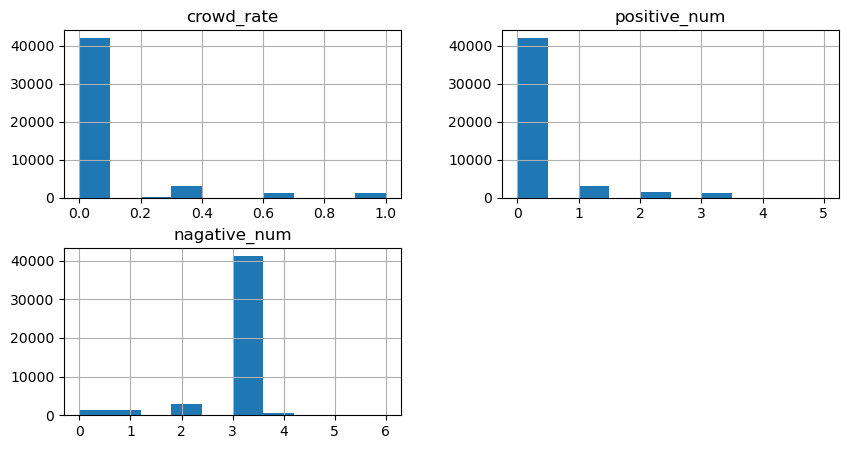

In [9]:
df_crowd.hist(figsize=(10, 5));

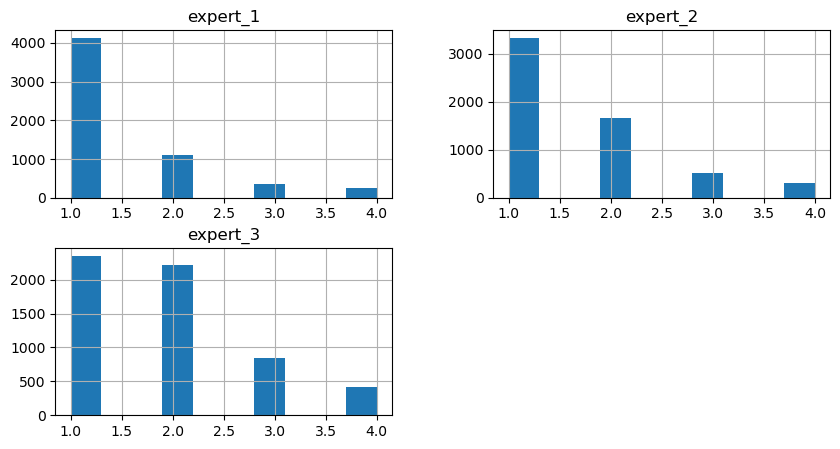

In [10]:
df_expert.hist(figsize=(10, 5));

Агрегируем оценки трех экспертов, найдем среднее и нормализуем в шкалу от 0-1, так мы приведем два типа оценов к одному  виду, а также нам легче будет интерпретировать оценки с точки зрения вероятности совпадения опписания и изображения.

In [11]:
df_expert['expert_rate'] = (
(
    (df_expert['expert_1']-1+ #сдвигаем оценки на 1, так чтобы шкала была не от 1-4, а от 0-3
    df_expert['expert_2']-1+
    df_expert['expert_3']-1) /3 #находим среднее среди 3х экспертов
    ) / 3 #делим на 3 для нормализации данных в шкаоле от 0-3 к шкале 0-1. так как у нас пропорция 1:3
    )

In [12]:
df_expert['expert_rate'].describe()

count    5822.000000
mean        0.215886
std         0.268735
min         0.000000
25%         0.000000
50%         0.111111
75%         0.333333
max         1.000000
Name: expert_rate, dtype: float64

агрегация и нормализация оценок прошла нормально , все оценки теперь по шкаоле от 0-1

Для более лаконичного проведения анализа числовых данных создадим функцию для построения графиков.

In [13]:
def eda_number(data, column, plot_title, x_label):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))  # 2 графика вертикально
    
    # Гистограмма с медианой и средним
    bins = axes[0].hist(data[column], bins=50, color='skyblue', edgecolor='black')
    axes[0].vlines(
        x=data[column].mean(), 
        ymin=0, 
        ymax=bins[0].max(), 
        colors='blue', 
        linestyles='solid', 
        label=f'Среднее = {data[column].mean():.2f}'
    )
    axes[0].vlines(
        x=data[column].median(), 
        ymin=0, 
        ymax=bins[0].max(), 
        colors='red', 
        linestyles='dashed', 
        label=f'Медиана = {data[column].median():.2f}'
    )
    axes[0].set_ylabel('Частота')
    axes[0].set_title(plot_title)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Ящик с усами (boxplot)
    axes[1].boxplot(data[column], vert=False, patch_artist=True)
    axes[1].set_xlabel(x_label)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()  # Автоматическая регулировка отступов
    plt.show()
    
    display(data[column].describe().to_frame().T)  # Красивое отображение статистик

Сначала посмотрим на распределение оценок краудсорсинга

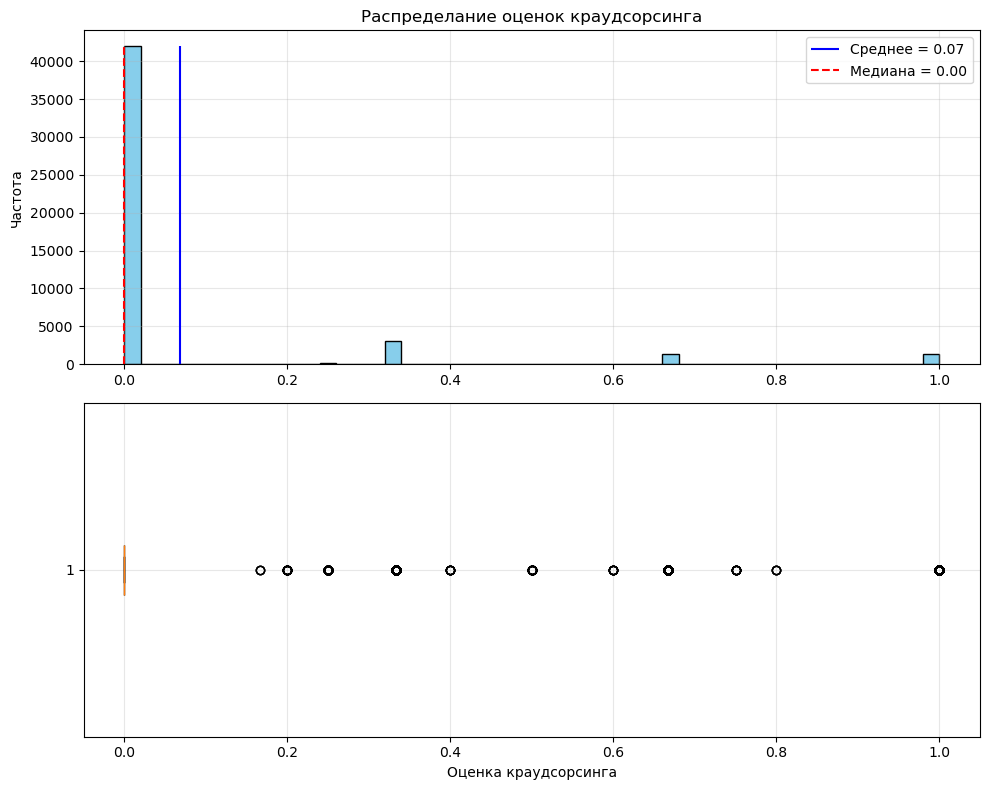

count      mean       std  min  25%  50%  75%  max
crowd_rate  47830.0  0.068786  0.207532  0.0  0.0  0.0  0.0  1.0

In [14]:
eda_number(df_crowd, 'crowd_rate', 'Распределание оценок краудсорсинга', 'Оценка краудсорсинга')

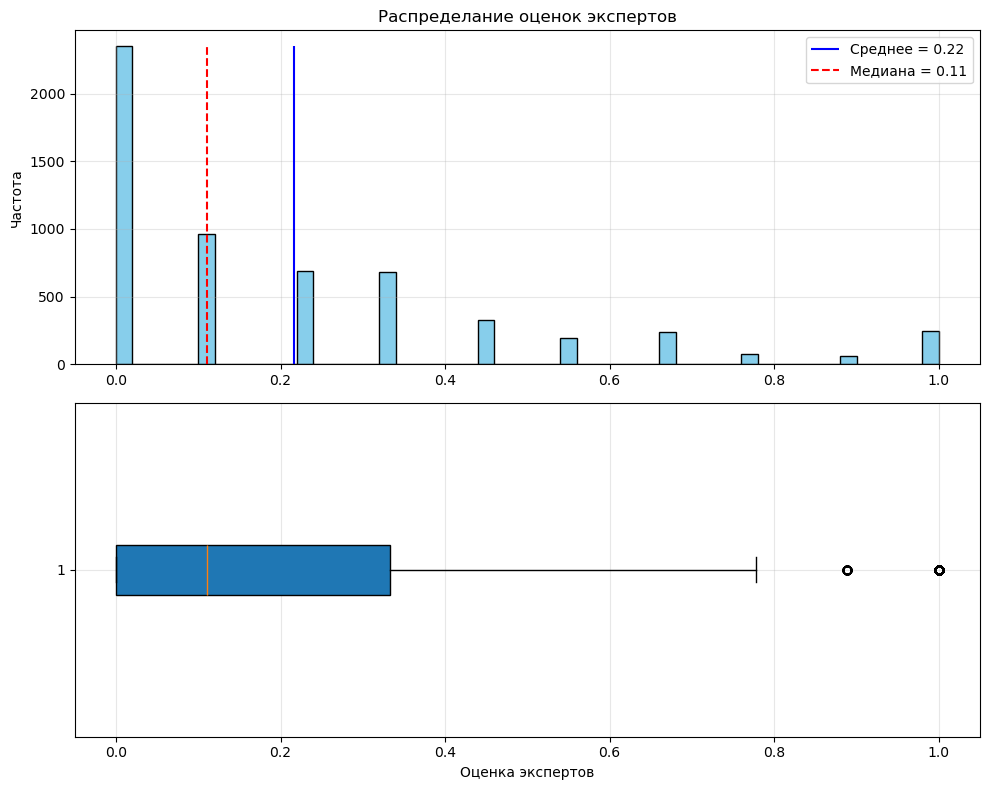

count      mean       std  min  25%       50%       75%  max
expert_rate  5822.0  0.215886  0.268735  0.0  0.0  0.111111  0.333333  1.0

In [15]:
eda_number(df_expert, 'expert_rate', 'Распределание оценок экспертов', 'Оценка экспертов')

In [16]:
len(train_df['image'].unique())

1000

Графически видно. что среди оценок по крудсорсингу преобладает 0, что одначает , что если доверять этим оценкам , то можно сделать однозначный вывод, что описания почти всегда не соотвествуют изображениям. У экспертов чуть более позитивная картина. Да, большинство оценок свидетельствует о том же , о чем и оценкт краудсорсинга, что описание действительном не соотвествует изображению, но здесь чаще чем в краудсорсинге втречаются и другие оценки. Да, оценок, указывающих на абсолютное соотвествие по прежнему мало, но появляются менее категоричные, указывающие на то , что совпадения есть но не совсем точные.  

### Добавление нового признака

Создадим признака, который будет участвовать в обучении, и будет объединять в себя значения оценок экспертов и краудсорсинга. Оценки экспертов яаляются более доверительными и весомыми , поэтому их значения будем использовать с коэффициентом 0.9, а оценки краудсорсинга с коэффициентом 0.1.

In [17]:
train_df =  train_df.merge(
    df_expert[['image', 'query_id', 'expert_rate']],  
    on=['image', 'query_id'], 
    how='left').merge(
        df_crowd[['image', 'query_id', 'crowd_rate']],
        on=['image', 'query_id'],
        how='left')
if train_df['crowd_rate'].isna:
    train_df['rate'] = train_df['expert_rate']
else:
    df_train['rate'] = (train_df['expert_rate']*0.85+train_df['crowd_rate']*0.15)
print('df_train')
func_info(train_df)

df_train


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  expert_rate  crowd_rate  \
0  A young child is wearing blue goggles and sitt...     0.000000         0.0   
1  A young child is wearing blue goggles and sitt...     0.000000         NaN   
2  A young child is wearing blue goggles and sitt...     0.222222         0.0   
3  A young child is wearing blue goggles and sitt...     1.000000         1.0   
4  A young child is wearing blue goggles and sitt...     0.000000         NaN   

       rate  
0  0.000000  
1  0.000000  
2  0.222222  
3  1.000000  
4  0.000000

expert_rate   crowd_rate         rate
count  5822.000000  2329.000000  5822.000000
mean      0.215886     0.198283     0.215886
std       0.268735     0.343315     0.268735
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.111111     0.000000     0.111111
75%       0.333333     0.333333     0.333333
max       1.000000     1.000000     1.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_id     5822 non-null   object 
 2   query_text   5822 non-null   object 
 3   expert_rate  5822 non-null   float64
 4   crowd_rate   2329 non-null   float64
 5   rate         5822 non-null   float64
dtypes: float64(3), object(3)
memory usage: 273.0+ KB


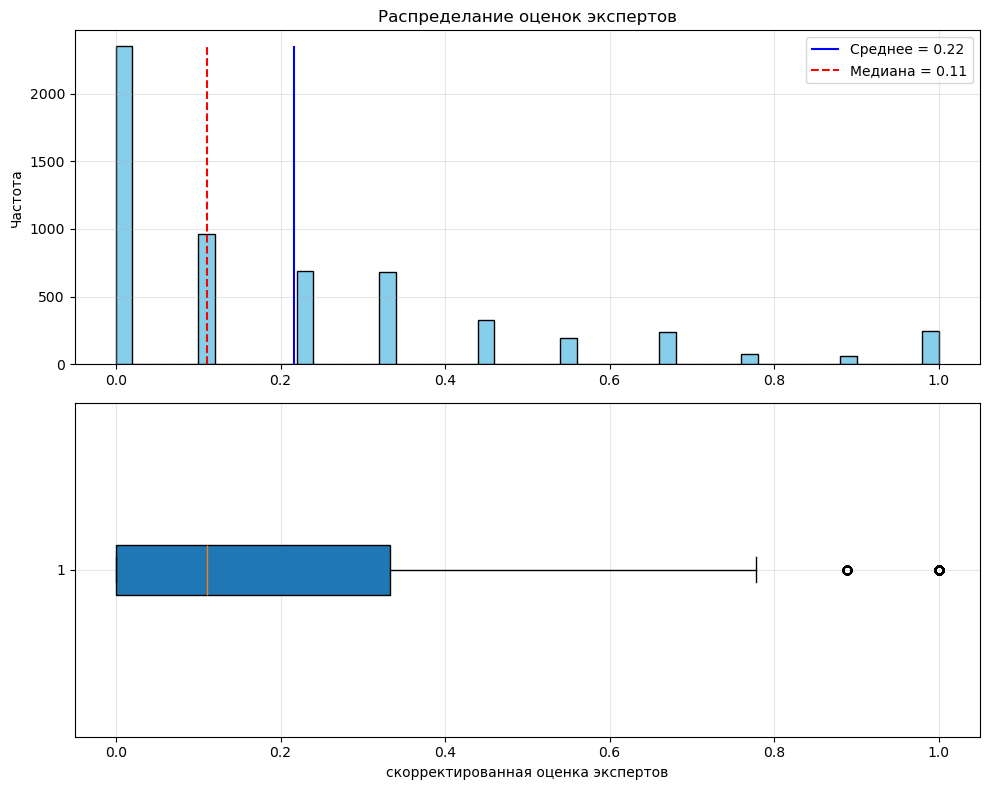

count      mean       std  min  25%       50%       75%  max
rate  5822.0  0.215886  0.268735  0.0  0.0  0.111111  0.333333  1.0

In [18]:
eda_number(train_df, 'rate', 'Распределание оценок экспертов', 'скорректированная оценка экспертов')

Видим , что новый признак по статистическим показателям идентичен оценкам экспертов, во-первых потому что после объединения таблиц в оценках краудсорсинга образовалось много пропусков, а в этом случае в общую оценку записалась оценка экспертов, во-вторых, потому что оценка краудсорсинга для расчета общей оценки взята с маленьким весом. 

Сформируем итоговый датасет, который будем использовать в обучении модели.

In [19]:
train_df = train_df.drop(['expert_rate', 'crowd_rate'], axis=1)
train_df

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text      rate  
0     A young child is wearing blue goggles and sitt...  0.000000  
1     A young child is wearing blue goggles and sitt...  0.000000  
2     A young child is wearing blue goggles and sitt...  0.222222  
3     A young child is wearing blue goggles and sitt...  1.000000  
4     A young child is wearing blue goggles and sitt...  0.000000  
...                                                 ...       ...  
5817         A man in an ampitheater talking to a boy .  0.444444  
5818          a old man walks down the uncrowded road .  0.000000  
5819       A dog stands on the side of a grassy cliff .  0.333333  
5820                       A blurry photo of two dogs .  0.555556  
5821                        A man rows his boat below .  0.000000  

[5822 rows x 4 columns]

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Отфильтруем и удалим строки , в описании которых встречаются слова релевантные детям

In [20]:
train_df['groups'] = train_df['image'].astype(str) + '_' + train_df['query_id'].astype(str)

In [21]:
train_df.sample(10)

image                     query_id  \
564   2460797929_66446c13db.jpg   533713007_bf9f3e25b4.jpg#2   
5290  2971431335_e192613db4.jpg  1456393634_74022d9056.jpg#2   
434    113678030_87a6a6e42e.jpg  3186412658_2ab2ebd397.jpg#2   
755   2921094201_2ed70a7963.jpg  2581066814_179d28f306.jpg#2   
466   1339596997_8ac29c1841.jpg   541063517_35044c554a.jpg#2   
5112  2602085456_d1beebcb29.jpg  3364861247_d590fa170d.jpg#2   
2601  3685328542_ab999b83bb.jpg   498444334_a680d318a1.jpg#2   
3036  3238951136_2a99f1a1a8.jpg   241031254_0c6f30e3d1.jpg#2   
3601  2470486377_c3a39ccb7b.jpg  2797149878_bb8e27ecf9.jpg#2   
1868  3155390408_8e1a81efb2.jpg  1786425974_c7c5ad6aa1.jpg#2   

                                             query_text      rate  \
564          Child sitting at a backyard picnic table .  0.222222   
5290           A child doing a handstand on the beach .  0.000000   
434   Team members being lifted up high to catch a f...  0.000000   
755                         Naked people riding bikes .  0.000000   
466   A man in grey on a rocky cliff , overlooking t...  0.000000   
5112  A woman in a pink sweater looks pensive next t...  0.222222   
2601                 Five young men pose on the steps .  0.111111   
3036  A man wearing a water pack and shorts on an ou...  0.555556   
3601            A little boy is holding a fishing rod .  0.111111   
1868   A smaller dog sniffs a larger dog in the hills .  0.222222   

                                                 groups  
564   2460797929_66446c13db.jpg_533713007_bf9f3e25b4...  
5290  2971431335_e192613db4.jpg_1456393634_74022d905...  
434   113678030_87a6a6e42e.jpg_3186412658_2ab2ebd397...  
755   2921094201_2ed70a7963.jpg_2581066814_179d28f30...  
466   1339596997_8ac29c1841.jpg_541063517_35044c554a...  
5112  2602085456_d1beebcb29.jpg_3364861247_d590fa170...  
2601  3685328542_ab999b83bb.jpg_498444334_a680d318a1...  
3036  3238951136_2a99f1a1a8.jpg_241031254_0c6f30e3d1...  
3601  2470486377_c3a39ccb7b.jpg_2797149878_bb8e27ecf...  
1868  3155390408_8e1a81efb2.jpg_1786425974_c7c5ad6aa...

train_df

In [22]:
children_keywords = ['young', 'boy', 'boys', 'girl', 'girls',
                    'child', 'children', 'baby', 'babies', 'newborn',
                    'kid', 'kids', 'teenager', 'teenagers', 'teens', 
                    'junior', 'juniors']
# Функция для проверки наличия ключевых слов
def contains_child(text):
    return any(word in text for word in children_keywords)
train_df['query_text'] = train_df['query_text'].str.lower()
forbiden_df = train_df[(train_df['query_text'].apply(contains_child)) & (train_df['rate']>0.5)]
forbiden_df

image                     query_id  \
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
16    2718495608_d8533e3ac5.jpg  2718495608_d8533e3ac5.jpg#2   
21     700884207_d3ec546494.jpg  2718495608_d8533e3ac5.jpg#2   
47    2370481277_a3085614c9.jpg  3545652636_0746537307.jpg#2   
51    2913965136_2d00136697.jpg  3545652636_0746537307.jpg#2   
...                         ...                          ...   
5536  2963573792_dd51b5fbfb.jpg  2963573792_dd51b5fbfb.jpg#2   
5542   542317719_ed4dd95dc2.jpg  2963573792_dd51b5fbfb.jpg#2   
5654  3143155555_32b6d24f34.jpg   398662202_97e5819b79.jpg#2   
5775   542317719_ed4dd95dc2.jpg   542317719_ed4dd95dc2.jpg#2   
5777   758921886_55a351dd67.jpg   542317719_ed4dd95dc2.jpg#2   

                                             query_text      rate  \
3     a young child is wearing blue goggles and sitt...  1.000000   
16    a girl wearing a yellow shirt and sunglasses s...  1.000000   
21    a girl wearing a yellow shirt and sunglasses s...  0.555556   
47    a young boy dressed in a red uniform kicks the...  0.555556   
51    a young boy dressed in a red uniform kicks the...  0.666667   
...                                                 ...       ...   
5536  a young girl is sliding down a slide at a play...  1.000000   
5542  a young girl is sliding down a slide at a play...  0.666667   
5654        two babies in sweaters playing with a toy .  0.555556   
5775  a smiling child slides down a slippery tube slide  0.666667   
5777  a smiling child slides down a slippery tube slide  1.000000   

                                                 groups  
3     2549968784_39bfbe44f9.jpg_2549968784_39bfbe44f...  
16    2718495608_d8533e3ac5.jpg_2718495608_d8533e3ac...  
21    700884207_d3ec546494.jpg_2718495608_d8533e3ac5...  
47    2370481277_a3085614c9.jpg_3545652636_074653730...  
51    2913965136_2d00136697.jpg_3545652636_074653730...  
...                                                 ...  
5536  2963573792_dd51b5fbfb.jpg_2963573792_dd51b5fbf...  
5542  542317719_ed4dd95dc2.jpg_2963573792_dd51b5fbfb...  
5654  3143155555_32b6d24f34.jpg_398662202_97e5819b79...  
5775  542317719_ed4dd95dc2.jpg_542317719_ed4dd95dc2....  
5777  758921886_55a351dd67.jpg_542317719_ed4dd95dc2....  

[139 rows x 5 columns]

In [23]:
# фцнкция для вывода изображений
def show_img(data):
    df_sample = data.head(16)
    datagen = ImageDataGenerator(rescale=1./255)

    datagen_flow = datagen.flow_from_dataframe(
    dataframe=df_sample,
    directory=img_folder_path,
    x_col='image',
    y_col='rate',
    target_size=(224, 224),
    batch_size=16,          # загружаем сразу 916 штук
    class_mode=None,
    shuffle=False
)

    features = next(datagen_flow)
    # выводим 16 изображений
    fig = plt.figure(figsize=(10,10))
    for i in range(16):
        fig.add_subplot(4, 4, i+1)
        plt.imshow(features[i])

         # Получаем оценку и описание
        rate = int(df_sample.iloc[i]["rate"])
        query_text = df_sample.iloc[i]["query_text"]  # или другой столбец

        # Разбиваем текст на строки с переносами
        wrapped_text = textwrap.fill(query_text, width=20)
    
        # Формируем заголовок
        plt.title(f'Оценка: {rate}\n{wrapped_text}', fontsize=6)  # \n для переноса строки
        # для компактности удаляем оси и прижимаем изображения друг к другу
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()



Found 16 validated image filenames.


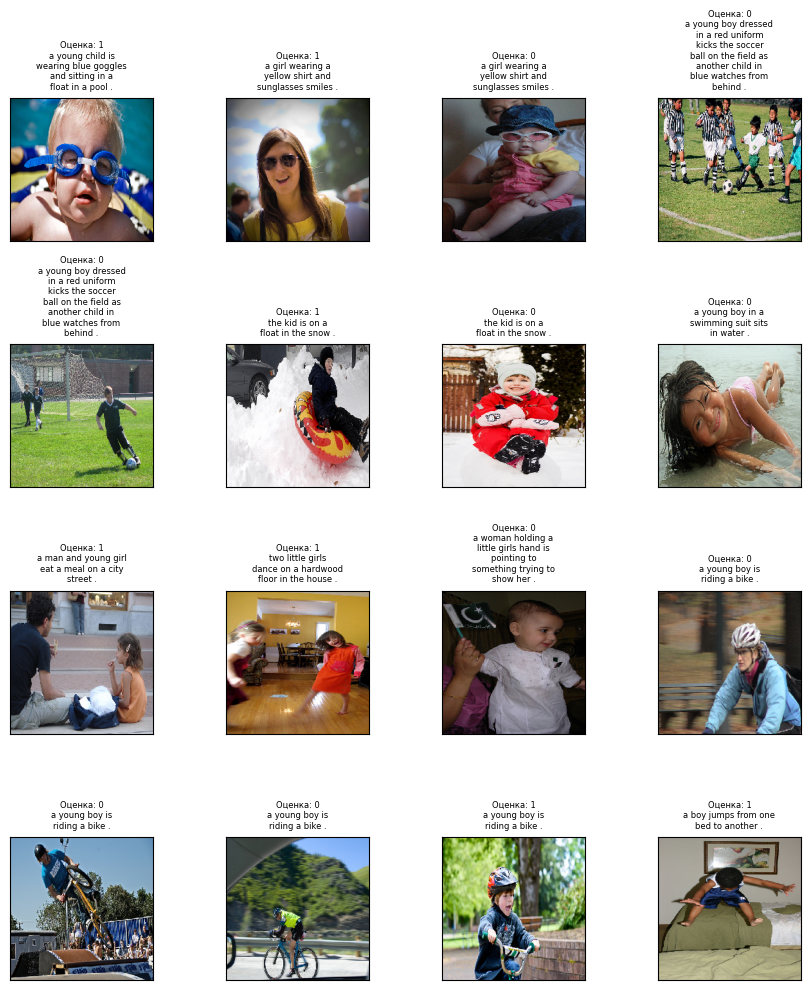

In [24]:
show_img(forbiden_df)

In [25]:
forbiden_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139 entries, 3 to 5777
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       139 non-null    object 
 1   query_id    139 non-null    object 
 2   query_text  139 non-null    object 
 3   rate        139 non-null    float64
 4   groups      139 non-null    object 
dtypes: float64(1), object(4)
memory usage: 6.5+ KB


удаляем картинки , которые содержат инфо о детях из основного датасета. сможем сделать это через индекс.

In [26]:
filtered_df = train_df[~train_df['groups'].isin(forbiden_df['groups'])]

In [27]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5683 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5683 non-null   object 
 1   query_id    5683 non-null   object 
 2   query_text  5683 non-null   object 
 3   rate        5683 non-null   float64
 4   groups      5683 non-null   object 
dtypes: float64(1), object(4)
memory usage: 266.4+ KB


Found 16 validated image filenames.


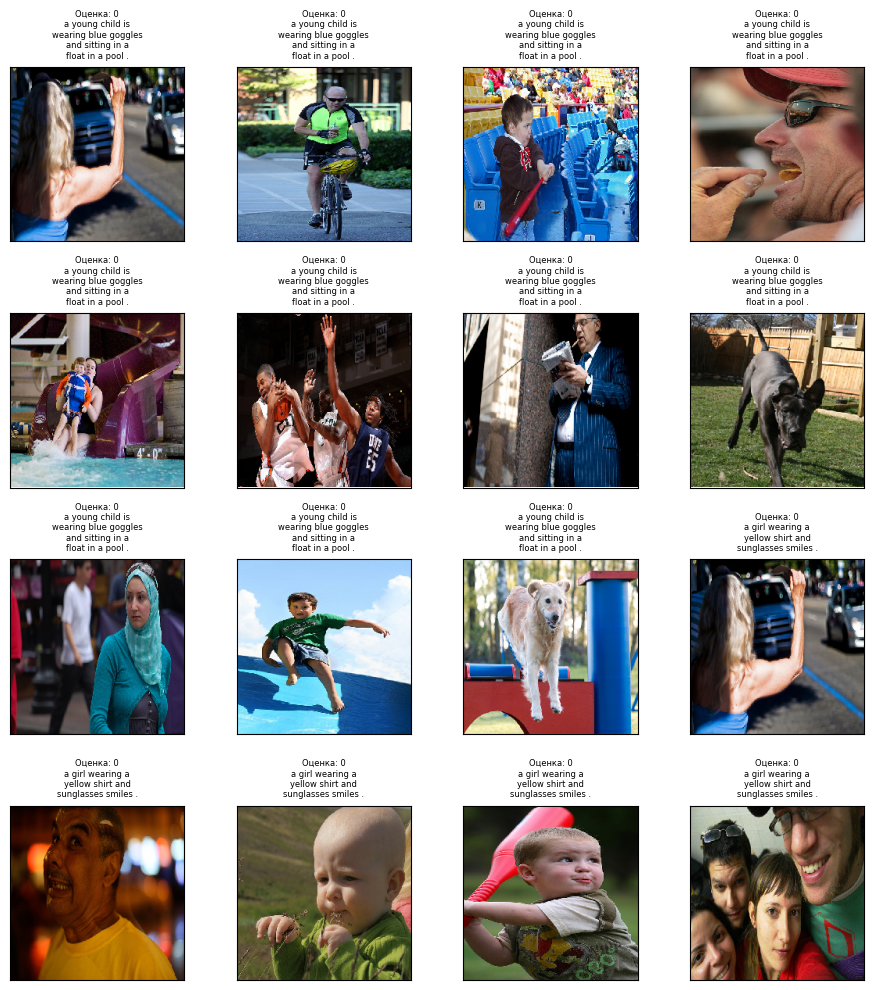

In [28]:
show_img(filtered_df)

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [29]:
filtered_df = filtered_df.reset_index(drop=True)

In [30]:
len(filtered_df['image'].unique())

1000

In [31]:
# load image
def image_vector(data, img_folder_path):
    df = data
    datagen = ImageDataGenerator(rescale=1/255.)

    datagen_flow = datagen.flow_from_dataframe(
        df,
        directory=img_folder_path,
        x_col='image',
        y_col=None,
        target_size=(224, 224),
        batch_size=16,
        class_mode=None,
        shuffle=False,
      #  subset='training',
        seed=12345)
    
    #создаем модель для векторизации
    resnet = ResNet50( 
                   weights='imagenet', 
                   include_top=False, 
                   pooling='avg',
                   input_shape=(224, 224, 3))

    image_vectors = resnet.predict(datagen_flow, verbose=1)
    image_embedding = image_vectors.reshape(image_vectors.shape[0], -1)
    data['image_embedding'] = list(image_embedding)
    print('image_embedding.shape:', image_embedding.shape)  
    return data['image_embedding']


In [32]:
image_vector(filtered_df, img_folder_path)

Found 5683 validated image filenames.
356/356 [==============================] - 715s 2s/step
image_embedding.shape: (5683, 2048)


0       [0.0, 0.0, 0.007829763, 0.0, 1.220196, 0.0, 0....
1       [0.0, 0.0, 0.0, 0.0, 0.934269, 0.0, 0.0, 0.621...
2       [0.0, 0.0, 0.0018150101, 0.0, 1.208234, 0.0, 0...
3       [0.0, 0.0, 0.0, 0.0, 1.2475468, 0.0, 0.0, 1.00...
4       [0.0, 0.0, 0.008741851, 0.0, 1.0062612, 0.0, 0...
                              ...                        
5678    [0.0, 0.0, 0.0, 0.0, 1.2928771, 0.0, 0.0, 0.74...
5679    [0.0, 0.0, 5.290946e-05, 0.0, 1.2553215, 0.0, ...
5680    [0.0, 0.0, 0.0, 0.0, 1.205414, 0.0, 0.0, 0.933...
5681    [0.0, 0.0, 0.0, 0.0, 1.3287113, 0.0, 0.0, 0.92...
5682    [0.0, 0.0, 0.0, 0.0, 1.2475027, 0.0, 0.0, 0.93...
Name: image_embedding, Length: 5683, dtype: object

#добавить генерацию веткоров только для уникальных картинок и далее мердж с основным датасетом

In [33]:
func_info(filtered_df)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
4  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text      rate  \
0  a young child is wearing blue goggles and sitt...  0.000000   
1  a young child is wearing blue goggles and sitt...  0.000000   
2  a young child is wearing blue goggles and sitt...  0.222222   
3  a young child is wearing blue goggles and sitt...  0.000000   
4  a young child is wearing blue goggles and sitt...  0.444444   

                                              groups  \
0  1056338697_4f7d7ce270.jpg_2549968784_39bfbe44f...   
1  1262583859_653f1469a9.jpg_2549968784_39bfbe44f...   
2  2447284966_d6bbdb4b6e.jpg_2549968784_39bfbe44f...   
3  2621415349_ef1a7e73be.jpg_2549968784_39bfbe44f...   
4  3030566410_393c36a6c5.jpg_2549968784_39bfbe44f...   

                                     image_embedding  
0  [0.0, 0.0, 0.007829763, 0.0, 1.220196, 0.0, 0....  
1  [0.0, 0.0, 0.0, 0.0, 0.934269, 0.0, 0.0, 0.621...  
2  [0.0, 0.0, 0.0018150101, 0.0, 1.208234, 0.0, 0...  
3  [0.0, 0.0, 0.0, 0.0, 1.2475468, 0.0, 0.0, 1.00...  
4  [0.0, 0.0, 0.008741851, 0.0, 1.0062612, 0.0, 0...

rate
count  5683.000000
mean      0.202377
std       0.255997
min       0.000000
25%       0.000000
50%       0.111111
75%       0.333333
max       1.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5683 entries, 0 to 5682
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            5683 non-null   object 
 1   query_id         5683 non-null   object 
 2   query_text       5683 non-null   object 
 3   rate             5683 non-null   float64
 4   groups           5683 non-null   object 
 5   image_embedding  5683 non-null   object 
dtypes: float64(1), object(5)
memory usage: 266.5+ KB


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [34]:
def text_vector(data):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")   
    data['query_embedding'] = data['query_text'].apply(lambda x: np.array(tokenizer.encode(x, padding='max_length')))
    return data['query_embedding']

In [35]:
text_vector(filtered_df)

0       [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...
1       [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...
2       [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...
3       [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...
4       [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...
                              ...                        
5678    [101, 1037, 2158, 1999, 2019, 23713, 8939, 524...
5679    [101, 1037, 2214, 2158, 7365, 2091, 1996, 4895...
5680    [101, 1037, 3899, 4832, 2006, 1996, 2217, 1997...
5681    [101, 1037, 14819, 2854, 6302, 1997, 2048, 607...
5682    [101, 1037, 2158, 10281, 2010, 4049, 2917, 101...
Name: query_embedding, Length: 5683, dtype: object

In [36]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5683 entries, 0 to 5682
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            5683 non-null   object 
 1   query_id         5683 non-null   object 
 2   query_text       5683 non-null   object 
 3   rate             5683 non-null   float64
 4   groups           5683 non-null   object 
 5   image_embedding  5683 non-null   object 
 6   query_embedding  5683 non-null   object 
dtypes: float64(1), object(6)
memory usage: 310.9+ KB


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [37]:
print(type(filtered_df['image_embedding'].iloc[0]))
print(type(filtered_df['query_embedding'].iloc[0]))
print(filtered_df['image_embedding'].iloc[0].shape)
print(filtered_df['query_embedding'].iloc[0].shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(2048,)
(512,)


In [38]:
def concat_embeddding(data):
    data['concat_embedding'] = data.apply(
        lambda x: np.concatenate([x['image_embedding'], x['query_embedding']]), 
        axis=1
        )
    return data['concat_embedding'] 

In [39]:
concat_embeddding(filtered_df)
print(type(filtered_df['concat_embedding'].iloc[0]))
print(filtered_df['concat_embedding'].iloc[0].shape)

<class 'numpy.ndarray'>
(2560,)


## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Подготовка данных для обучения

In [40]:
filtered_df.head(2)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  rate  \
0  a young child is wearing blue goggles and sitt...   0.0   
1  a young child is wearing blue goggles and sitt...   0.0   

                                              groups  \
0  1056338697_4f7d7ce270.jpg_2549968784_39bfbe44f...   
1  1262583859_653f1469a9.jpg_2549968784_39bfbe44f...   

                                     image_embedding  \
0  [0.0, 0.0, 0.007829763, 0.0, 1.220196, 0.0, 0....   
1  [0.0, 0.0, 0.0, 0.0, 0.934269, 0.0, 0.0, 0.621...   

                                     query_embedding  \
0  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...   
1  [101, 1037, 2402, 2775, 2003, 4147, 2630, 2175...   

                                    concat_embedding  
0  [0.0, 0.0, 0.007829762995243073, 0.0, 1.220196...  
1  [0.0, 0.0, 0.0, 0.0, 0.9342690110206604, 0.0, ...

In [41]:
df = filtered_df[['image', 'query_id', 'rate', 'groups', 'concat_embedding']]
features = df[['groups', 'concat_embedding']]
target = df['rate']

print(features.shape)
print(target.shape)


(5683, 2)
(5683,)


In [42]:
# Разбиваем данные на train (70%) и test (30%)
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=features, 
                                             y=target, 
                                             groups=features['groups']))
train_data, test_data = df.loc[train_indices], df.loc[test_indices]


X_train = train_data['concat_embedding']
y_train = train_data['rate']
X_test = test_data['concat_embedding']
y_test = test_data['rate']

Подготовим несколько моделей -  Модель линейной регрессии , нейронную сеть .   

 Таргет имеет сильно несбалансированное распределение (75% значений в 0-0.33 и много нулей), стандартные метрики регрессии (MAE, RMSE) могут давать неполную картину из-за обилия нулей - Модель может научиться предсказывать близко к 0, игнорируя остальные значения. Обучим модели , получим метрики , сделаем выводы. 

In [43]:
X_train = np.vstack(X_train.values)
X_test = np.vstack(X_test.values)
y_train = y_train.values
y_test = y_test.values


In [44]:
#входные признаки для обучения и таргет
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (3978, 2560)
y_train (3978,)
X_test (1705, 2560)
y_test (1705,)


Статистика y_train: count    3978.000000
mean        0.203424
std         0.257292
min         0.000000
25%         0.000000
50%         0.111111
75%         0.333333
max         1.000000
dtype: float64


c:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


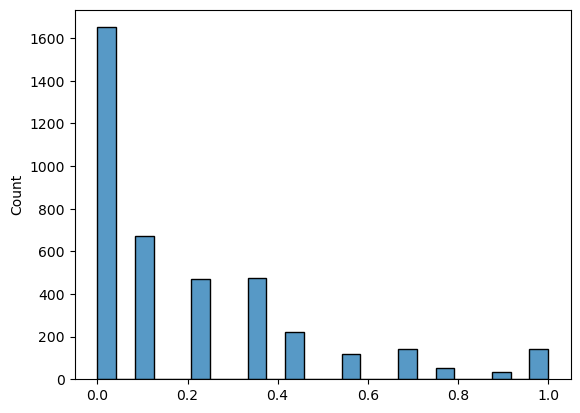

NaN в X_train: 0


In [45]:
# Проверим распределение rate
print("Статистика y_train:", pd.Series(y_train).describe())
sns.histplot(y_train)
plt.show()

# Проверим, нет ли NaN в X_train
print("NaN в X_train:", np.isnan(X_train).sum())

Статистика y_train: count    1705.000000
mean        0.199935
std         0.253009
min         0.000000
25%         0.000000
50%         0.111111
75%         0.333333
max         1.000000
dtype: float64


c:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


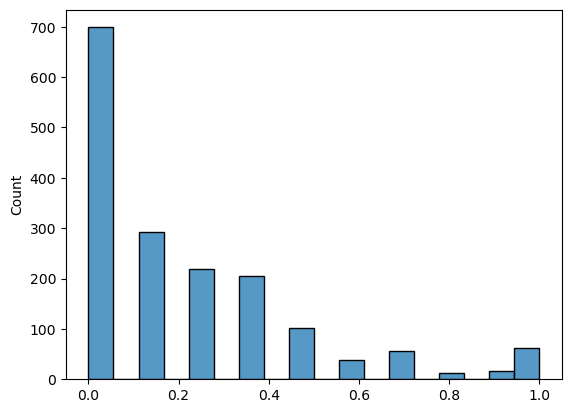

NaN в X_test: 0


In [46]:
# Проверим распределение rate
print("Статистика y_train:", pd.Series(y_test).describe())
sns.histplot(y_test)
plt.show()

# Проверим, нет ли NaN в X_train
print("NaN в X_test:", np.isnan(X_test).sum())

### Модель линейной регрессии

In [47]:
model_linr = LinearRegression(n_jobs=-1)
scores_linr = cross_val_score(model_linr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

In [48]:
print(f'rmse на тренировочной выборке: {-scores_linr}')
print(f'rmse на тренировочной выборке: {-np.median(scores_linr)}')

rmse на тренировочной выборке: [ 7907699.07154094    44665.32377098 13818069.23327156   253750.61444158
   921374.92227363]
rmse на тренировочной выборке: 921374.9222736334


### Модель CatBoost

In [49]:
cat_model = CatBoostRegressor(iterations=100,
                              verbose=0, 
                              random_seed=RANDOM_STATE
                              )


# Сетка гиперпараметров для RandomizedSearchCV
param_distributions = {  
    'learning_rate': [0.01, 0.1, 0.5],  
    'depth': [4, 5, 6, 7]
}

randomized_search_cat = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_distributions,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=1
)

# Обучаем модель
randomized_search_cat.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000021B808A4710>,
                   n_jobs=1,
                   param_distributions={'depth': [4, 5, 6, 7],
                                        'learning_rate': [0.01, 0.1, 0.5]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [50]:
print('Лучшие параметры:\n\n', randomized_search_cat.best_params_)

print('RMSE  на тренировочной выборке:', -randomized_search_cat.best_score_)

Лучшие параметры:

 {'learning_rate': 0.1, 'depth': 5}
RMSE  на тренировочной выборке: 0.2463905875627427


### Модель нейронная сеть

In [51]:
model = Sequential(name='RegressionModel')
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))  
model.add(BatchNormalization())
# model.add(Dropout(0.3))  
model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1, activation='linear')) 


model.compile(
    optimizer = Adam(learning_rate=1e-3) ,
    loss='mse',  # Для регрессии
    metrics=[RootMeanSquaredError()] 
)


In [52]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
249/249 [==============================] - 6s 13ms/step - loss: 0.1476 - root_mean_squared_error: 0.3841 - val_loss: 0.1200 - val_root_mean_squared_error: 0.3464
Epoch 2/50
249/249 [==============================] - 3s 12ms/step - loss: 0.0866 - root_mean_squared_error: 0.2944 - val_loss: 0.0832 - val_root_mean_squared_error: 0.2884
Epoch 3/50
249/249 [==============================] - 3s 11ms/step - loss: 0.0772 - root_mean_squared_error: 0.2779 - val_loss: 0.0767 - val_root_mean_squared_error: 0.2769
Epoch 4/50
249/249 [==============================] - 3s 12ms/step - loss: 0.0714 - root_mean_squared_error: 0.2672 - val_loss: 0.0757 - val_root_mean_squared_error: 0.2751
Epoch 5/50
249/249 [==============================] - 3s 11ms/step - loss: 0.0687 - root_mean_squared_error: 0.2622 - val_loss: 0.0715 - val_root_mean_squared_error: 0.2673
Epoch 6/50
249/249 [==============================] - 3s 12ms/step - loss: 0.0671 - root_mean_squared_error: 0.2590 - val_loss: 0.0696 

Лучшая модель - Catboost. протестируем ее

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### Предсказание вероятности для тестовой выборки

Сначала создадим эмбеддинги для тестовой выборки

In [53]:
image_vector(test_queries_df, img_folder_path_test)
text_vector(test_queries_df)
concat_embeddding(test_queries_df)


Found 500 validated image filenames.
32/32 [==============================] - 71s 2s/step
image_embedding.shape: (500, 2048)


0      [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...
1      [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...
2      [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...
3      [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...
4      [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...
                             ...                        
495    [0.0, 0.0, 0.0, 0.0, 1.020279049873352, 0.0, 0...
496    [0.0, 0.0, 0.0, 0.0, 1.020279049873352, 0.0, 0...
497    [0.0, 0.0, 0.0, 0.0, 1.020279049873352, 0.0, 0...
498    [0.0, 0.0, 0.0, 0.0, 1.020279049873352, 0.0, 0...
499    [0.0, 0.0, 0.0, 0.0, 1.020279049873352, 0.0, 0...
Name: concat_embedding, Length: 500, dtype: object

In [54]:
test_queries_df.head(5)

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  \
0  1177994172_10d143cb8d.jpg   
1  1177994172_10d143cb8d.jpg   
2  1177994172_10d143cb8d.jpg   
3  1177994172_10d143cb8d.jpg   
4  1177994172_10d143cb8d.jpg   

                                     image_embedding  \
0  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   
1  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   
2  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   
3  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   
4  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   

                                     query_embedding  \
0  [101, 2048, 9081, 3337, 1010, 2028, 1999, 1037...   
1  [101, 2048, 3337, 2024, 5490, 10179, 24097, 23...   
2  [101, 2048, 3337, 29035, 2169, 2060, 2007, 230...   
3  [101, 2048, 2336, 4147, 6312, 5490, 10179, 533...   
4  [101, 2048, 2402, 3337, 2024, 5490, 10179, 240...   

                                    concat_embedding  
0  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...  
1  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...  
2  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...  
3  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...  
4  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...

Созадем признаки для тестирования

In [55]:
X_test = test_queries_df['concat_embedding']
X_test = np.vstack(X_test.values)

In [56]:
predpredictions = model.predict(X_test)

test_queries_df['rate'] = predpredictions

16/16 [==============================] - 0s 3ms/step


Ниже напишем функцию . показывающую наимболее релевантное изображение к случаному запросу


In [58]:
func_info(test_queries_df)

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  \
0  1177994172_10d143cb8d.jpg   
1  1177994172_10d143cb8d.jpg   
2  1177994172_10d143cb8d.jpg   
3  1177994172_10d143cb8d.jpg   
4  1177994172_10d143cb8d.jpg   

                                     image_embedding  \
0  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   
1  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   
2  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   
3  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   
4  [0.0, 0.0, 0.016493196, 0.0, 1.0136276, 0.0, 0...   

                                     query_embedding  \
0  [101, 2048, 9081, 3337, 1010, 2028, 1999, 1037...   
1  [101, 2048, 3337, 2024, 5490, 10179, 24097, 23...   
2  [101, 2048, 3337, 29035, 2169, 2060, 2007, 230...   
3  [101, 2048, 2336, 4147, 6312, 5490, 10179, 533...   
4  [101, 2048, 2402, 3337, 2024, 5490, 10179, 240...   

                                    concat_embedding      rate  
0  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...  0.086801  
1  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...  0.183004  
2  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...  0.189098  
3  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...  0.183807  
4  [0.0, 0.0, 0.016493195667862892, 0.0, 1.013627...  0.236731

rate
count  500.000000
mean     0.187730
std      0.158808
min     -2.212070
25%      0.137232
50%      0.183335
75%      0.237470
max      1.028272

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   query_id          500 non-null    object 
 1   query_text        500 non-null    object 
 2   image             500 non-null    object 
 3   image_embedding   500 non-null    object 
 4   query_embedding   500 non-null    object 
 5   concat_embedding  500 non-null    object 
 6   rate              500 non-null    float32
dtypes: float32(1), object(6)
memory usage: 29.3+ KB


### Функция вывода релевантного изображания

In [60]:
def proper_image(df, images_folder, num_samples=10):

    # Выбираем случайные описания (без повторов)
    unique_descriptions = df['query_text'].unique()
    selected_descriptions = random.sample(list(unique_descriptions), min(num_samples, len(unique_descriptions)))



        # Создаем фигуру для отображения
    plt.figure(figsize=(12, 5 * num_samples))


    for i, description in enumerate(selected_descriptions):
        # Находим все записи с этим описанием
        group_description = df[df['query_text'] == description]
        
        # Находим запись с максимальным rate (лучшее соответствие)
        best_match = group_description.loc[group_description['rate'].idxmax()]
        
         # Создаем subplot для текущего примера
        ax = plt.subplot(num_samples, 1, i+1)
        
        # Вывод текста описания
        plt.text(
            0.5, 0.9, 
            f"Описание: {description}\n наибольшая вероятность: {best_match['rate']:.2f}", 
            fontsize=10, 
            ha='center', 
            va='top',
            wrap=True
        )
        
        # Загрузка и вывод изображения
        img_path = os.path.join(images_folder, best_match['image'])
        try:
            img = Image.open(img_path)
            # Вставка изображения в нижнюю часть subplot
            img_ax = ax.inset_axes([0.1, 0.1, 0.8, 0.6])  # [x, y, width, height]
            img_ax.imshow(img)
            img_ax.axis('off')
        except Exception as e:
            plt.text(
                0.5, 0.5, 
                f"Ошибка загрузки: {best_match['image']}", 
                color='red',
                ha='center'
            )
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

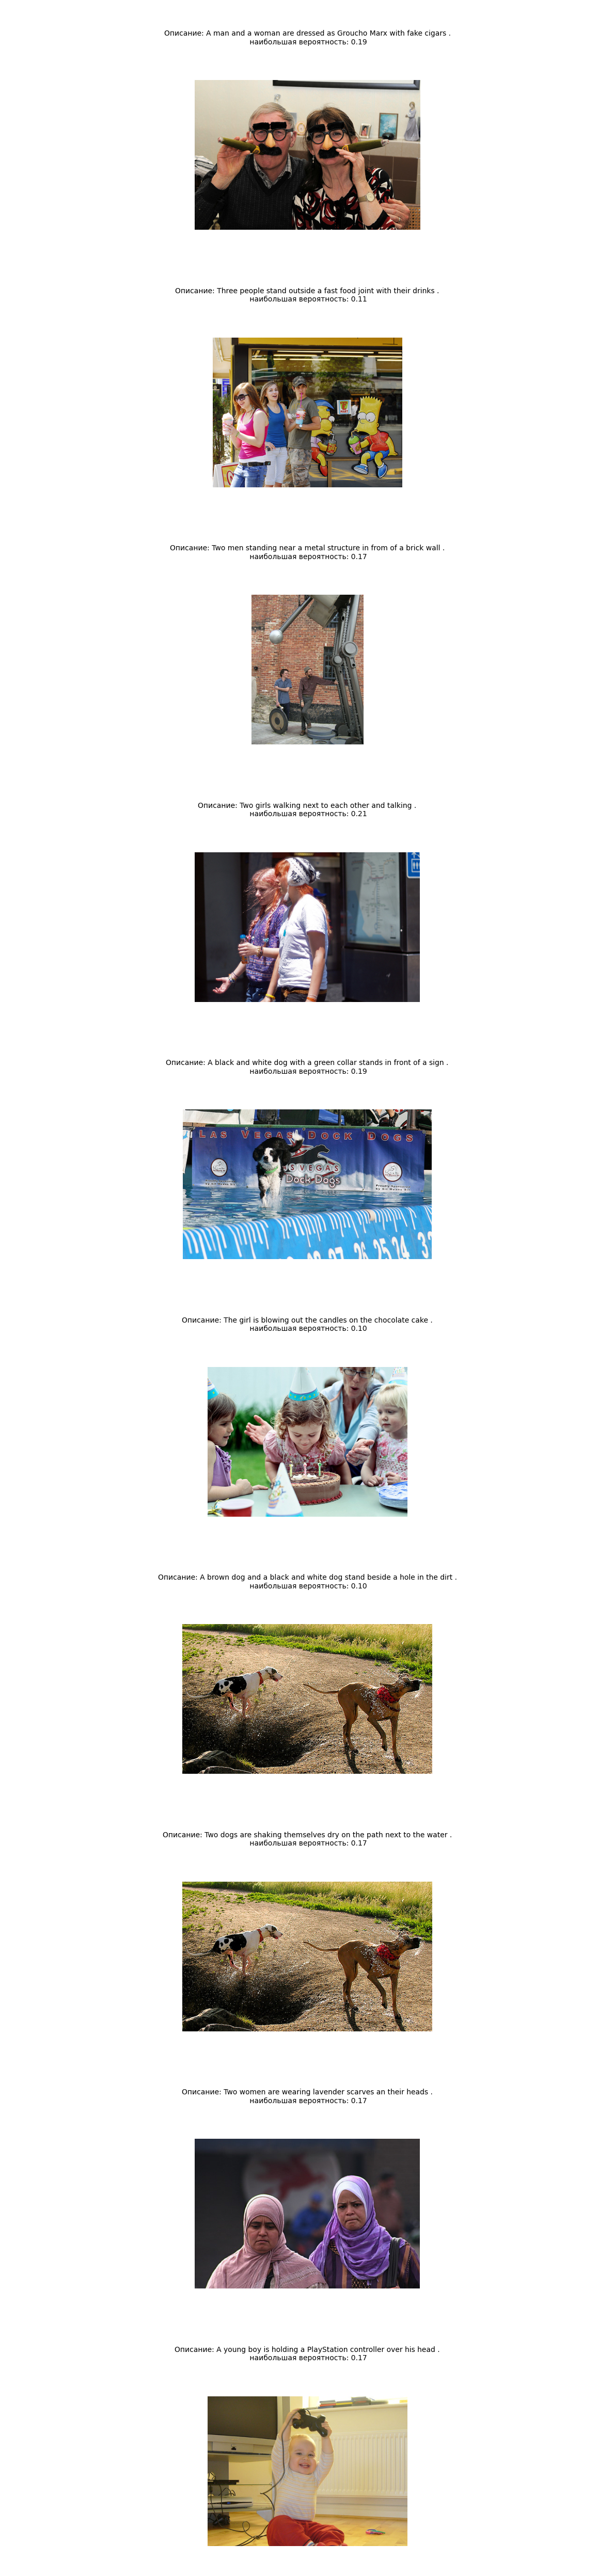

In [65]:
proper_image(test_queries_df, img_folder_path_test, num_samples=10)

здравствуйте, подскажите, пожалуйста, нужно ли при тестировании применять юридические ограничения. Скорее всего да. сделать не успела пока.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска

В ходе выполнения проекта были загружены данные , содержащие информацию об изображениях и описаниях к ним , а также оценки релевантности описаний с точки зрения экспертов и круадсорсинга. Исследовательский анализ данных показал, что среди оценок по крудсорсингу преобладает 0, что означает , что если доверять этим оценкам , то можно сделать однозначный вывод, что описания почти всегда не соотвествуют изображениям. У экспертов чуть более позитивная картина. Да, большинство оценок свидетельствует о том же , о чем и оценки краудсорсинга, что описание действительном не соотвествует изображению, но здесь чаще чем в краудсорсинге втречаются и более высокая релевантность. Да, оценок, указывающих на абсолютное соотвествие по прежнему мало, но появляются менее категоричные, указывающие на то , что совпадения все-таки есть, хоть и не совсем точные. Было приянто решение агрегировать  два вида оценок  - созвдать признака, который будет участвовать в обучении. Так оценки экспертов являются более доверительными и весомыми , поэтому их значения использованы с коэффициентом 0.9, а оценки краудсорсинга с коэффициентом 0.1, что позволило лишь на малую долю скореектировать мнение экспертов.  

Необходимо было учесть юридическую составляющую , и отфильтровать изображения с детьми, опираясь на стоп-слова в описании и оценки экспертов. Если вероятность соттветствия изображения описанию выше 0,3, и в описании содержатся слова, относящиеся к детской теме, то такие пары - описание+картинка были исключены из датасета, участвующего в обучении.

На следующем этапе был создан общий вектор изображения и текста с помощью моделей Resnet50 и  Bert соответственно.  

Для обучения модели признаки были подготовлены, разбиты с помощью GroupShuffleSplit.  

В обучении учатвовало 3 модели - линейная регрессия, Catboost, нейронная сеть. Метрика оценки качества модели  - RMSE. Линейная регрессия хуже всего справилась с заданием из-за большого объема данных. Размерность признаокв  2516 . Лучшую метрику показал Catboost. С помощью этой модели и сделали предсказания для тестовой выборки. 

При тестировании была создна функция, позволяющая выводить наиболее релевантное изображение для 10 случайных описаний. 

